## SNO+ Scattering Pseudo-MC
A simple test using known results to determine the viability of nuclear recoil
explaining the odd behaviour at 2.2 MeV.

In [31]:
# importing the usual suspects
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from multiprocessing import Pool

# random number generation
import random
# i just picked an arbitrary seed here
# if it matters it's easy to change
random.seed("snoplus")

plt.rcParams['figure.figsize'] = (12, 8)

In [32]:
# now we read in the stopping power data from ASTAR
stoppingpowers = pd.read_csv(Path("stoppingpowers/paraffin.csv"))
# rename cols to make them easier to reference
stoppingpowers.columns = ["KE", "electron", "nuclear", "total"]
# reindex the dataframe by kinetic energy to make lookups easier
#stoppingpowers.set_index("KE", inplace=True)
print(stoppingpowers)

            KE  electron    nuclear  total
0       0.0010     194.0  289.00000  483.0
1       0.0015     233.0  260.00000  493.0
2       0.0020     266.0  238.00000  503.0
3       0.0025     294.0  219.00000  514.0
4       0.0030     320.0  204.00000  524.0
..         ...       ...        ...    ...
116   800.0000      19.1    0.00655   19.1
117   850.0000      18.4    0.00617   18.4
118   900.0000      17.7    0.00582   17.7
119   950.0000      17.1    0.00552   17.2
120  1000.0000      16.6    0.00524   16.6

[121 rows x 4 columns]


So now we have the stopping power data available to us and formatted nicely.

**NB**: the initial revision here is without scattering to get a grip on things

The setup is that we have some sort of particle with a given energy E_0 (i'm not sure exactly what yet -
need to figure that out)
The general process goes like this:
- Look up stopping power in the table for the energy of our event
- Find dE (**NOTE**: need to figure out what dx will be here first - see
  wikipedia page for stopping power)
- Add dE to the bin for an event of that energy
- Repeat this, as if we had an energy of E_j = E_0 - dE
- Terminate once E_j is less than some given epsilon (generally close to zero -
  but we will never reach zero exactly)

Implementation notes: Can use recursion, but that is setting myself up for a
nightmare so let's keep things iterative

Also - how to deal with events which aren't exactly a given KE in the table.
Data is nonlinear but describes the derivative of energy w.r.t. position - the
function "looks like" it is C-infinity (ie. continuous derivatives) and differentiability
implies linearity in a neighbourhood so a linear interpolation should be a very
accurate estimation 

In [33]:
# Let's set up the bins for events here
# I don't know of any prepackaged solution for this so let's write a structure
# to hold binned data for us

# this kind of seems unnecessary to me, but also I would be implementing the
# exact same logic in a messier form otherwise so I digress
class CountBin:
    def __init__(self, low, high):
        self._low = low
        self._high = high
        self._count = 0
    
    # setting properties for the bin count
    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, new_count):
        self._count = new_count

    # increment and decrement convenience functions
    def increment(self):
        self.count = self._count + 1       

    def decrement(self):
        self.count = self._count - 1

    # properties for bin bounds
    @property
    def low_range(self):
        return self._low

    @property
    def high_range(self):
        return self._high

    def __str__(self):
        return f"CountBin(low={self.low_range}, high={self.high_range}, count={self.count})"
    

class BinnedCountData:
    def __init__(self, num_bins, d=None, startpoint=0, endpoint=1):
        if d != None:
            low = min(d)
            high = max(d)
        else:
            low = startpoint
            high = endpoint

        self.binEdges = np.linspace(low, high, num_bins+1)

        self.bins = []

        i = 0
        while i < len(self.binEdges)-1:
            self.bins.append(CountBin(self.binEdges[i], self.binEdges[i+1]))
            i += 1


    def get_bin_index(self, v):
        i = 0
        while i < len(self.binEdges) - 1:
            if v <= self.binEdges[i+1]:
                return i
            i += 1


    @property
    def bin_min(self):
        return min(self.binEdges)
    
    @property
    def bin_max(self):
        return max(self.binEdges)

    @property
    def bin_edges(self):
        return self.binEdges

    @property
    def num_bins(self):
        return len(self.bins)

    # add a value to the correct count bin
    def add_count_by_value(self, v):
        # TODO is there a faster algorithm for this?
        self.bins[self.get_bin_index(v)].increment()

    # count an entire list
    def add_count_by_list(self, l):
        for i in l:
            self.count_value(i)

    def set_count_by_index(self, idx, c):
        self.bins[idx].count = c

    @property
    def counts(self):
        return [i.count for i in self.bins]

    def get_count_by_value(self, v):
        # get count of a bin some value is in
        return self.bins[self.get_bin_index(v)].count

Now we do the linear interpolation of the ASTAR data
Although the data is nonlinear, this is still decently accurate since it is a differentiable function 

In [34]:
# now to do the linear interpolation for the ASTAR dataset
def stp_interp(e, stp=stoppingpowers):
    # NOTE this assumes that the stopping powers are sorted
    # we get them this way from ASTAR so it's not an issue, but we can fix that if need be
    for k in stoppingpowers.index:
        if e >= stoppingpowers["KE"].max():
            return (stoppingpowers["total"].iloc(-1))/(stoppingpowers["KE"].iloc(-1))*e
        elif e <= stoppingpowers["KE"][k+1] and e >= stoppingpowers["KE"][k]:
            ke_low = stoppingpowers["KE"][k]
            sp_low = stoppingpowers["total"][k]
            ke_high = stoppingpowers["KE"][k+1]
            sp_high = stoppingpowers["total"][k+1]
            break

    return ((sp_high - sp_low)/(ke_high - ke_low)) * e + sp_low


Here we define a function to compute the scattering probability for each event

In [35]:
def scattering_probability(ke, dx):
    sample_dim = 1 # cm

    N_A = 6.02214E23 # mol^-1
    mol_wt = 246.43 # for LAB, need to verify
    rho = 0.863 # g/cm^3, see above
    n = ((N_A/mol_wt) * rho)*(sample_dim**2)*dx
    # effective area based on cross-section
    Z = 48 
    D = ((197.3/137) * (2*Z)/ke)*1E-15
    sigma = 130.646*4*np.pi*np.power(D, 2)
    # total particle effective area
    eff_a = sigma*n

    # the total area
    total_a = sample_dim**2
    return  eff_a/total_a


And now let's write a function to sample from the differential cross-section as a distribution

In [47]:
def diff_cx(theta, ke):
    Z = 48
    D = ((198.3/137) * (2*Z)/ke)*1E-15
    return np.pi/4 * D**2 * (np.cos(theta/2)/np.power(np.sin(theta/2),3))

def scaled_diff_cx(theta, ke):
    # luckily, our differential crossection is a decreasing function on the interval we care about
    # so, we just take the left endpoint as our x-value
    theta_min = 0.174533
    scale = 1/(diff_cx(theta_min, ke))
    return diff_cx(theta,ke)*scale

def scattering_angle(ke):
    theta_min = 0.174533
    Z = 48
    while True:
        # first we sample from a uniform distribution of valid x-values
        xsample = random.uniform(theta_min, np.pi)
        # then find the scaled differential crosssection at the x-sample
        scx = scaled_diff_cx(xsample, ke)
        # and then return the x-sample if a random number is less than that value
        if random.random() < scx:
            return xsample

Now to determine the change in momentum from the scattering

We start with
$$ \frac{q}{p} = 2\sin{\frac{\theta}{2}} $$

Where q is the change in momentum, p is the total momentum (which is just the initial momentum of the $\alpha$-particle) and $\theta$ is the scattering angle.

We rearrange this to obtain

$$ q = 2p\sin{\frac{\theta}{2}} $$

Moreover, recall that we have 
$$ E_{\alpha} = \frac{1}{2}m_{\alpha}v_{\alpha}^2 $$

and that 
$$ p = mv $$

Combining these, we obtain
$$ q = 2m_{\alpha}\sqrt{\frac{2E_{\alpha}}{m_{\alpha}}}\sin\frac{\theta}{2} $$

Assuming that the proton is initially at rest, we obtain

$$ v_{p} = 2\frac{m_{\alpha}}{m_{p}}\sqrt{\frac{2E_{\alpha}}{m_{\alpha}}}\sin{\frac{\theta}{2}} $$

Which gives us a kinetic energy of
$$ E_p = \frac{1}{2}m_pv_p^2 $$

Now, let's do the simulation.

In [37]:
def scatter_sim(e_0, epsilon=0.1, density=0.92, stepsize=0.001, sim_data=None):
    if sim_data is None:
        data = BinnedCountData(40, startpoint=0, endpoint=e_0)
    else:
        data = sim_data

    # now to run the simulation
    e_i = e_0
    while e_i > epsilon:
        if scattering_probability(e_i, stepsize) > random.random():
            # here, we need to figure out the change in momentum and energy due to the scattering
            # both the proton and alpha particle will cause an event, so we need to tally both
            pass
        else:
            data.add_count_by_value(e_i)
            e_i = e_i - stp_interp(e_i)*stepsize*density
    if sim_data is None:
        return data


In [53]:
# ok, now let's write a loop to process a lot of particles
# using one on each thread to speed things up
# considering this is a toy model, let's just use one thread for each particle

def merge_hists(hists: list[BinnedCountData]):
    low = hists[0].bin_min
    high = hists[0].bin_max
    n_bins = hists[0].num_bins
    new_hist = BinnedCountData(n_bins, startpoint=low, endpoint=high)

    i = 0
    while i < n_bins:
        new_hist.set_count_by_index(i, sum([k.counts[i] for k in hists]))
        i += 1

    return new_hist

def run_sim_instance(e_0, stepsize=0.0001, nbins=80, epsilon=0.1, density=0.92):
    run_data = BinnedCountData(nbins, startpoint=0, endpoint=e_0)
    scatter_sim(e_0, epsilon=epsilon, density=density, stepsize=stepsize, sim_data=run_data)
    return run_data

def sim_wrapper(arg):
    args, kwargs = arg
    return run_sim_instance(*args, **kwargs)

# TODO sort out arguments properly
def start_sim(e_0, n_particles, stepsize=0.001, nbins=40, epsilon=0.1, density=0.92):
    arg = (e_0, )
    kwargs = {'stepsize': stepsize, 'nbins': nbins, 'epsilon': epsilon, 'density': density}
    with Pool() as p:
        p_out = p.map(sim_wrapper, [(arg, kwargs) for i in range(n_particles)])

    sim_data = merge_hists(p_out) 
    return sim_data 

sim_data = start_sim(14, 1000, stepsize=0.0001)

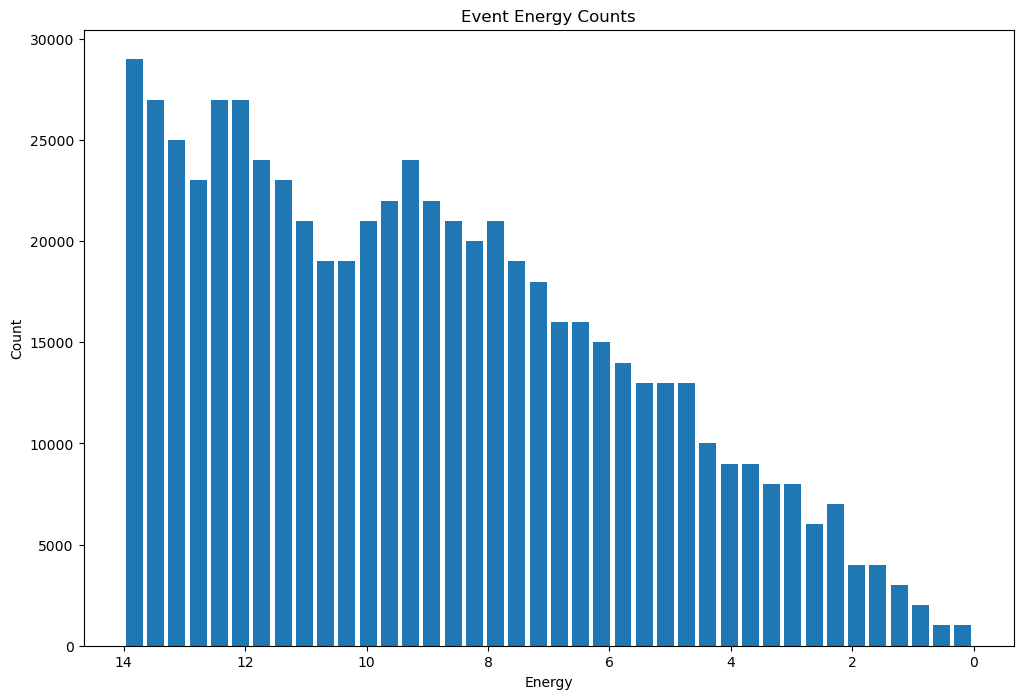

In [54]:
# now to plot the simulation results
#plt.stairs(sim_data.counts, sim_data.bin_edges)
plt.hist(sim_data.bin_edges[:-1], sim_data.bin_edges, weights=sim_data.counts, rwidth=0.8)
plt.xlabel("Energy")
plt.ylabel("Count")
plt.gca().invert_xaxis()
plt.title("Event Energy Counts")
plt.show()